# Project Title: 
# Social Media and Music Streaming: Joining the Twitter and Spotify APIs

## Project Description:

The code provided constructs of a clean database that sucessfully joins information on social media use (Twitter API) and music streaming behavior. These APIs are sucessfully integrated via unique music track identifiers present in the scraped websites of Spotify media urls shared in Twitter posts. The final database is primed for natural language processing (NLP) sentiment analysis in order to assess the relationship among valence of tweets, mood and linked musical media audio features (e.g., the "valence", "danceability", "energy", etc. of a track shared by a Twitter user). 

This database contains features falling into three major categories of information:

1. Twitter user demographics/twitter platform use metrics
2. Tweet content variables (including linked music media)
3. Spotify music attributes (including audio features of a track/artist/album/playlist)

NOTE: Please see the accompanying README.txt file for a full description of variables included in this database.

## Database Construction Schematic:

This database was constructed 5 steps:

1. Retrieve relevant Tweets with linked Spotify media using the Twython client
2. Clean/tokenize free-text Twitter API fields (e.g., Tweet Text)
3. Visit the expanded_urls of Tweets with linked Spotify media and scrape the unique track id(s) using beautiful soup
4. Retrieve track information/audio features for scraped track ids using Spotipy client
5. Integrate Twitter and Spotify data into single nested .json

<img src='final_database_construction_schematic.png' width="750" height="750">

### Requirements:

NOTE: Pip installation of the following modules may be required: spotipy, twython, spacy, bs4, wordcloud

In [46]:
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import datetime
from twython import Twython
import regex as re
import pickle
import spacy
import requests
import bs4
import pandas as pd
import collections
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

### Step 1: Search Twitter API for Spotify Relevant Tweets

#### Accessing Twitter API

NOTE: You must sign up for a Twitter Developer account in order to obtain Twitter API credentials. 
    The process requires a project description and registration of an application.
    To build this database, a paid premium account is required to acess the fullarchive API endpoint.

In [47]:
# Loading twitter credentials from json file
with open("twitter_credentials.json", "r") as cred_file1:  
    twitter_creds = json.load(cred_file1)

In [48]:
def build_desired_tweet_dict(query):
    """
    Takes a Twython query (dict of parameters) and returns a list of dictionaries 
    containing information on Twitter statuses from the full archive, whose criteria 
    match the given query.
    
    @query: dict (contains search criteria for a tweet, e.g., spotify_query)
    @return: list<dict>
    """
    #Sets limit on number of API calls
    max_attempts = 500
    
    #Defines full archive API endpoint for query
    api_url = 'https://api.twitter.com/1.1/tweets/search/fullarchive/dsdev.json'
    
    #Instantiates a Twython object w/ credentials
    desired_tweets = Twython(twitter_creds['CONSUMER_KEY'], twitter_creds['CONSUMER_SECRET'])
    
    #Initalizes empty list where a dictionary for each tweet will be appended
    desired_tweet_list = []
        
    for i in range(0, max_attempts):
        if 0 == i: #Running query for first iteration w/o max_id parameter
            response = desired_tweets.search(**query, endpoint=api_url, count=500)
        
        else: #Running query for subsequent iteractions w/ max_id paramater for pagination
            response = desired_tweets.search(**query, include_entities='true', max_id=next_max_id, count=500)
   
        for status in response['statuses']:
            desired_tweet_dict = {}
            
            #User variables:
            desired_tweet_dict['User ID'] = status['user']['id']
            desired_tweet_dict['User Name'] = status['user']['name']
            desired_tweet_dict['User Screename'] = status['user']['screen_name']
            desired_tweet_dict['Member Since'] = status['user']['created_at']        
            desired_tweet_dict['User Profile Description'] = status['user']['description']
            desired_tweet_dict['User Location'] = status['user']['location']
            if status['user']['geo_enabled'] == True:
                desired_tweet_dict['Geo Location'] = status['geo']
                desired_tweet_dict['Coordinates'] = status['coordinates']
                desired_tweet_dict['Place'] = status['place']

            desired_tweet_dict['Follower Count'] = status['user']['followers_count']
            desired_tweet_dict['Friend Count'] = status['user']['friends_count']
            desired_tweet_dict['Status Count'] = status['user']['statuses_count']
            desired_tweet_dict['Favorites Count'] = status['user']['favourites_count']

            #Tweet variables:
            desired_tweet_dict['Tweet ID'] = status['id']
            desired_tweet_dict['Tweet Text'] = status['full_text']
            desired_tweet_dict['Creation Date Time'] = status['created_at']
            desired_tweet_dict['Retweet Count'] = status['retweet_count']
            desired_tweet_dict['Media URLs'] = status['entities']['urls'] #will want 'expanded_url' for scraping
            #To also capture retweeted URLs:
            #if 'retweeted_status' in status.keys():
            #    desired_tweet_dict['Retweeted URLs'] = status['retweeted_status']['entities']['urls']
            desired_tweet_dict['Hashtags'] = status['entities']['hashtags']
            desired_tweet_dict['Symbols'] = status['entities']['symbols']

            desired_tweet_list.append(desired_tweet_dict)
            
        try: #Parsing max_id for pagination if max_id provided in response        
            next_results_url_params = response['search_metadata']['next_results']
            next_max_id = next_results_url_params.split('max_id=')[1].split('&')[0]
            print(next_max_id)
            
        except: #Break if no more results to page through
            break
    
        #Tracking rate limit
        headers = ['x-rate-limit-limit', 'x-rate-limit-remaining', 'x-rate-limit-reset']

        for header in headers:
            print(header, desired_tweets.get_lastfunction_header(header))
        
        
    return desired_tweet_list

In [49]:
#Creating query dict used to retrieve relevant tweets

spotify_query = {'q': 'spotify',  #keyword query = spotify
        'lang': 'en', #language = english
        'maxResults': 500, #max tweets = 500 (upper limiti of API)
        'fromDate': 201412010000, #starting from data 12/01/2014, when expanded media URLs were added to API
        'url': 'open.spotify.com', #urls that contain the pattern 'open.spotify.com'
        'tweet_mode': 'extended' #get full tweet text
        }

NOTE: DO NOT RUN THE TWITTER API CALL BELOW. Pickled tweet data from this call can be loaded from file 'alltweets2'.

In [50]:
#Running API call w/ spotify query dict

#desired_tweet_list = build_desired_tweet_dict(spotify_query)

In [51]:
#Pickling all Tweets returned from build_desired_tweet_dict

#outfile0 = open('alltweets2.pickle','wb')
#pickle.dump(desired_tweet_list, outfile0)

In [52]:
#Loading pickled Twitter data (all retrieved tweets)

infile0 = open('alltweets2.pickle','rb')
unpickled_all_tweets = pickle.load(infile0)

#View on first 10 tweets
#pprint(unpickled_all_tweets[:10])
print('The length of all retrieved tweets is: ' + str(len(unpickled_all_tweets)))

The length of all retrieved tweets is: 34504


In [53]:
def get_relevant_tweets(tweet_list=unpickled_all_tweets):
    """
    Takes a list of tweet dicts returned from build_desired_tweet_dict
    (default = unpickeld_all_tweets) and returns a list of tweet dicts
    that have Media URLs.
    
    @tweet_list: list<dict> (tweet dicts)
    @return: list<dict> (tweets dicts w/ Media)
    """
    
    acceptable_spotify_urls = ['https://open.spotify.com/track', 'https://open.spotify.com/album',
                               'https://open.spotify.com/playlist', 'https://open.spotify.com/user',
                              'https://open.spotify.com/artist']
        
    tweets_with_spotify_urls = [tweet_dict for tweet_dict in tweet_list 
                                if tweet_dict['Media URLs'] != [] #or tweet_dict['Retweeted URLs'] != []
                                and any([tweet_dict['Media URLs'][0]['expanded_url'].startswith(url) 
                                         for url in acceptable_spotify_urls])]
            
    return tweets_with_spotify_urls

tweets_with_spotify_urls = get_relevant_tweets()

In [54]:
#Examining output of get_relevant_tweets
print("The total number of tweets with valid Spotify URLs is: " + str(len(tweets_with_spotify_urls)))

#Checking that relevant tweets have exapnded urls that start with acceptable Spotify Urls
acceptable_spotify_urls = ('https://open.spotify.com/track', 'https://open.spotify.com/album',
                            'https://open.spotify.com/playlist', 'https://open.spotify.com/user',
                          'https://open.spotify.com/artist')

print(all([[tweet_dict['Media URLs'][0]['expanded_url'].startswith(url) 
         for url in acceptable_spotify_urls]
         for tweet_dict in tweets_with_spotify_urls]))

#Checking that all spotify relevant Tweets are unique
uniqueTweetIDs = set()
for tweet_dict in tweets_with_spotify_urls:
    uniqueTweetIDs.add(str(tweet_dict['Tweet ID']))
    
print(len(uniqueTweetIDs) == len(tweets_with_spotify_urls))

The total number of tweets with valid Spotify URLs is: 11971
True
True


In [55]:
#Pickling Tweets returns from get_relevant_tweets (tweets w/ Spotify URLs)

#outfile1 = open('allspotifytweets.pickle','wb')
#pickle.dump(tweets_with_spotify_urls, outfile1)

In [56]:
#Loading pickled Twitter data (Spotify relevant tweets)

infile1 = open('allspotifytweets.pickle','rb')
unpickled_spotify_tweets = pickle.load(infile1)

#View on first 10 tweets w/ spotify URLs
#pprint(unpickled_spotify_tweets[:10])
print(len(unpickled_spotify_tweets) == len(tweets_with_spotify_urls))

True


### Step 2. Clean/Tokenize Retrieved Tweets

In [57]:
def clean_tweets(tweet_list=unpickled_spotify_tweets):
    """
    Takes a list of tweet dictionaries (default = unpickled_spotify_tweets)
    and returns a new list of tweet dictionaries where the fields 'Tweet Text',
    'User Profile Description', and 'User Name' have been cleaned 
    to allow for tokenization.
    
    @tweet_list: list<dict> (tweets)
    @return: list<dict> (tweets w/ clean text in 'Tweet Text' 
    'User Profile Description', 'User Name', 'User Location')
    """
    fields_to_clean = ['Tweet Text', 'User Profile Description', 'User Name', 'User Location']
    
    for tweet_dict in tweet_list:
        for field in fields_to_clean:
            tweet_dict[field] = re.sub("@[\w]*" , "" , tweet_dict[field]) #removes other users tagged in tweet text
            tweet_dict[field] = re.sub("RT", "" , tweet_dict[field]) #removes retweet tag (e.g., 'RT: @TheGoldenUnion')
            tweet_dict[field] = re.sub(":", "" , tweet_dict[field]) #removes :
            tweet_dict[field] = re.sub("\|", "", tweet_dict[field]) #removes |
            tweet_dict[field] = re.sub("•", "", tweet_dict[field]) #removes •
            tweet_dict[field] = re.sub("°", "", tweet_dict[field]) #removes °
            tweet_dict[field] = re.sub("∴", "", tweet_dict[field]) #removes ∴
            tweet_dict[field] = re.sub("˖", "", tweet_dict[field]) #removes ˖
            tweet_dict[field] = re.sub("↓", "", tweet_dict[field]) #revomes ↓
            tweet_dict[field] = re.sub("~", "", tweet_dict[field]) #removes ~
            tweet_dict[field] = re.sub("\*", "", tweet_dict[field]) #removes *
            tweet_dict[field] = re.sub("…", " ", tweet_dict[field]) #removes …
            tweet_dict[field] = re.sub("\.\.\.", " ", tweet_dict[field]) #removes ...
            tweet_dict[field] = re.sub("\n", "" , tweet_dict[field]) #removes line breaks
            tweet_dict[field] = re.sub(r"http\S+" , "" , tweet_dict[field]) #removes links
            tweet_dict[field] = re.sub(u"[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]" , "" , tweet_dict[field])
            tweet_dict[field] = re.sub("^\s+|\s+$", "", tweet_dict[field], flags=re.UNICODE)
            tweet_dict[field] = re.sub("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u'\U00010000-\U0010ffff'
                           u"\u200d"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\u3030"
                           u"\ufe0f"
                           "]+" , "" , tweet_dict[field])
            tweet_dict[field] = " ".join(re.split("\s+", tweet_dict[field], flags=re.UNICODE))

    return tweet_list

In [58]:
#Cleaning Spotify revelant Tweets

clean_spotify_tweets = clean_tweets()

In [59]:
#Testing clean_tweets()

print(len(clean_spotify_tweets) == len(unpickled_spotify_tweets))

#View on cleaned fields of first 50 tweets
sample_clean_tweet_text = [tweet_dict['Tweet Text'] for tweet_dict in clean_spotify_tweets[:50]]
#pprint(sample_clean_tweet_text)

sample_clean_profile_descrip = [tweet_dict['User Profile Description'] for tweet_dict in clean_spotify_tweets[:50]]
#pprint(sample_clean_profile_descrip)

sample_clean_user_name = [tweet_dict['User Name'] for tweet_dict in clean_spotify_tweets[:50]]
#pprint(sample_clean_user_name)

sample_clean_user_location = [tweet_dict['User Location'] for tweet_dict in clean_spotify_tweets[:50]]
#pprint(sample_clean_user_location)

True


In [60]:
def tokenize_tweet_text(clean_tweet_list=clean_spotify_tweets):
    """
    Takes a list of tweet dictionaries w/ pre-cleaned text 
    (returned from clean_tweets, default = clean_spotify_tweets)
    and returns a new list of tweet dictionaries with the following
    keys added: 'Tokenized Tweet Text', 'Tokenized User Profile Description'.
    
    @clean_tweet_list: list<dict> (tweets w/ clean text)
    @return: list<dict> (w/ new keys 'Tokenized Tweet Text', 
    'Tokenized User Profile Description', values are list<str> (tokenized text))
    """
    
    nlp = spacy.load('xx_ent_wiki_sm') #multi-language spaCy model, good for social media tokenization
    
    additional_stop_words = {'[', ']', ' ', ',', "'", "''", '.', '!', '  ', '-', '"', '>', '<', ')', '(', ':',
                            '..', '“', '”', '‘', '’', '#', '&', '?', 'amp', ';', '\\', '/', "'s", '’s'}
    
    for word in additional_stop_words:
        nlp.Defaults.stop_words.add(str(word))
    
    fields_to_tokenize = ['Tweet Text', 'User Profile Description']
    
    for tweet_dict in clean_tweet_list:
        for field in fields_to_tokenize:
            if tweet_dict[field] != '': #Deals w/ empty User Profile Descriptions
                tokenized_words = []
                doc = nlp(tweet_dict[field])
                for token in doc:
                    if token.text.lower() not in nlp.Defaults.stop_words:
                        tokenized_words.append(token.text.lower())
                    tweet_dict['Tokenized ' + field] = tokenized_words
            else:
                tweet_dict['Tokenized ' + field] = []
       
    return clean_tweet_list

In [61]:
#Tokenizing Tweet Text and User Profile Descriptions

tokenized_spotify_tweets = tokenize_tweet_text()

In [62]:
#Testing tokenize_tweet_text()

#Verifying every tweet dict now contains a 'Tokenized Tweet Text' and 'Tokenized User Profile Description' key
tweet_key_check = ['Tokenized Tweet Text' in tweet_dict.keys() for tweet_dict in tokenized_spotify_tweets]
print(all(tweet_key_check))

profile_key_check = ['Tokenized User Profile Description' in tweet_dict.keys() for tweet_dict in tokenized_spotify_tweets]
print(all(profile_key_check))


#View on tokenized fields of first 50 tweets
sample_tokenized_tweet_text = [tweet_dict['Tokenized Tweet Text'] for tweet_dict in tokenized_spotify_tweets[:50]]
#pprint(sample_tokenized_tweet_text)

sample_tokenized_profile_descrip = [tweet_dict['Tokenized User Profile Description'] for tweet_dict in tokenized_spotify_tweets[:50]]
#pprint(sample_tokenized_profile_descrip)

True
True


In [63]:
#Pickling tokenized_spotify_tweets list

#with open('tokenized_spotify_tweets.pickle', 'wb') as file_handle2:
#    pickle.dump(tokenized_spotify_tweets,file_handle2)

In [64]:
#Unpickling tokenized_spotify_tweets list
infile4 = open('tokenized_spotify_tweets.pickle','rb')

unpickled_tokenized_spotify_tweets = pickle.load(infile4)

#Verifying length
print(len(unpickled_tokenized_spotify_tweets) == len(unpickled_spotify_tweets))

#View on first 2 unpickled tokenized spotify tweets
sample_tokenized_tweets = unpickled_tokenized_spotify_tweets[:2]
#pprint(sample_tokenized_tweets)

True


### Step 3. Scrape Linked Spotify Sites for Track IDs

#### Accessing Spotify API 

NOTE: You must sign up for a Spotify Developer account in order to obtain Spotify API credentials. 
    The process requires a project description and registration of an application. 

In [65]:
#Loading Spotify credentials from json file
with open("spotify_credentials.json", "r") as cred_file0:  
    spotify_creds = json.load(cred_file0)

In [66]:
#Creates lists of spotify media linked in tweets for track id scraping
sites_to_scrape = [tweet['Media URLs'][0]['expanded_url'] for tweet in unpickled_spotify_tweets]

#Verifying the number of expected URLs were captured
print(len(sites_to_scrape) == len(unpickled_spotify_tweets))

#View on first 100 sites to scrape
#pprint(sites_to_scrape[:100])

sample_track_urls = [url for url in sites_to_scrape[:100] if url.startswith('https://open.spotify.com/track/')]
#pprint(sample_track_urls)

sample_album_urls = [url for url in sites_to_scrape[:100] if url.startswith('https://open.spotify.com/album/')]
#pprint(sample_album_urls)

sample_playlist_urls = [url for url in sites_to_scrape[:100] if url.startswith('https://open.spotify.com/playlist/')]
#pprint(sample_playlist_urls)

sample_user_urls = [url for url in sites_to_scrape[:100] if url.startswith('https://open.spotify.com/user/')]
#pprint(sample_user_urls)

sample_artist_urls = [url for url in sites_to_scrape[:100] if url.startswith('https://open.spotify.com/artist/')]
#pprint(sample_artist_urls)

True


In [67]:
def scrape_track_ids(urls):
    """
    Takes a list of urls (e.g., sites_to_scrape) and returns the
    list of track ids scraped from the Spotify sites.
    The list of track ids can be fed into the spotipy .audio_features
    method to retreive data on the attributes of the tracks.
    
    @urls: list<str> (expanded Spotify URLs from Twitter API)
    @return: list<str> (Spotify track IDs)
    """
    client_credentials_manager = SpotifyClientCredentials(client_id=spotify_creds['CLIENT_ID'], 
                                                      client_secret=spotify_creds['CLIENT_SECRET'])

    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    all_track_ids = []
    
    for url in urls:
        tracks_by_tweet = []
        print('Visiting: ' + url)
        response = requests.get(url)
        status = response.status_code
        print(status)
        
        if status == 200:
            if url.startswith('https://open.spotify.com/track/'):
                response = response.text
                soup = bs4.BeautifulSoup(response, 'html')
                track_tag = soup.find("meta", property="og:url")
                track_id = track_tag['content'][len('https://open.spotify.com/track/'):]
                tracks_by_tweet.append(track_id)
                all_track_ids.append(tracks_by_tweet)
                print('Sucessfully visited: ' + url)
                
            if url.startswith('https://open.spotify.com/album/'):
                response = response.text
                soup = bs4.BeautifulSoup(response, 'html')
                album_tag = soup.find("meta", property="og:url")
                album_id = album_tag['content'][len('https://open.spotify.com/album/'):]
                album_info = sp.album(album_id)['tracks']['items']
                for track_num in range(len(album_info)):
                    tracks_by_tweet.append(album_info[track_num]['id'])
                all_track_ids.append(tracks_by_tweet)
                print('Successfully visited: ' + url)
                
            if url.startswith('https://open.spotify.com/artist/'):
                response = response.text
                soup = bs4.BeautifulSoup(response, 'html')
                artist_tag = soup.find("meta", property="og:url")
                artist_id = artist_tag['content'][len('https://open.spotify.com/artist/'):]
                top_track_info = sp.artist_top_tracks(artist_id)['tracks']
                for track_num in range(len(top_track_info)):
                    tracks_by_tweet.append(top_track_info[track_num]['id'])
                all_track_ids.append(tracks_by_tweet)
                print('Successfully visited: ' + url)
            
            if url.startswith('https://open.spotify.com/playlist/') or url.startswith('https://open.spotify.com/user/'):
                response = response.text
                soup = bs4.BeautifulSoup(response, 'html')
                playlist_track_tags = soup.find_all("meta", property="music:song")
                for playlist_track_tag in playlist_track_tags:
                    playlist_track_id = playlist_track_tag['content'][len('https://open.spotify.com/track/'):]
                    tracks_by_tweet.append(playlist_track_id)
                all_track_ids.append(tracks_by_tweet)
                print('Successfully visited: ' + url)
        else:
            tracks_by_tweet.append('Bad response status: ' + str(status))
            all_track_ids.append(tracks_by_tweet)
            print('Unsuccessfully visited: ' + url)
    
    return all_track_ids

NOTE: DO NOT RUN THE THE SCRAPER BELOW. Pickled track id data from this call can be loaded from file 'all_track_ids'.

In [68]:
#Scraping all audio track ids

#all_track_ids = scrape_track_ids(sites_to_scrape)
#pprint(all_track_ids[:100])

In [69]:
#Pickling all_track_ids list

#with open('all_track_ids.pickle', 'wb') as file_handle0:
#    pickle.dump(all_track_ids,file_handle0)

In [70]:
#Unpickling all_track_ids list
infile2 = open('all_track_ids.pickle','rb')

unpickled_track_ids = pickle.load(infile2)

#Verifying length
print(len(unpickled_track_ids) == len(unpickled_spotify_tweets))

#View on first 10 unpickled track ids
sample_track_ids2 = unpickled_track_ids[:10]
#pprint(sample_track_ids2)

True


In [71]:
#Testing scrape_track_ids

track_test_scrape = scrape_track_ids(['https://open.spotify.com/track/7zGEU6BXl2c4TxpzIAr7BI?si=IVn1MXfzSYCq9AuivZsDzw'])
#pprint(track_test_scrape)
print(len(track_test_scrape[0]) == 1)

album_test_scrape = scrape_track_ids(['https://open.spotify.com/album/1AvXa8xFEXtR3hb4bgihIK'])
#pprint(album_test_scrape)
print(len(album_test_scrape[0]) == 7) #Checking all 7 track ids belonging to this album were retrieved

playlist_test_scrape = scrape_track_ids(['https://open.spotify.com/playlist/1eNJGhgsbOwNV6MBNEWpHV'])
#pprint(playlist_test_scrape)
print(len(playlist_test_scrape[0]) == 30) #Checking all 30 track ids belonging to this playlist were retrieved

user_test_scrape = scrape_track_ids(['https://open.spotify.com/user/6dzjdiyrstxaikz3ns28mqxly/playlist/3xDlnmeJzaYvHrlk9ONB3s?si=KnW8c967TjyXNnegOkbsZQ'])
#pprint(user_test_scrape)
print(len(user_test_scrape[0]) == 30)

artist_test_scrape = scrape_track_ids(['https://open.spotify.com/artist/5LLPRBNvmG89rnqtZDLIEL?si=iug0fg5ATQqOrvoVpADV2Q'])
#pprint(artist_test_scrape)
print(len(artist_test_scrape[0]) == 10)

Visiting: https://open.spotify.com/track/7zGEU6BXl2c4TxpzIAr7BI?si=IVn1MXfzSYCq9AuivZsDzw
200
Sucessfully visited: https://open.spotify.com/track/7zGEU6BXl2c4TxpzIAr7BI?si=IVn1MXfzSYCq9AuivZsDzw
True
Visiting: https://open.spotify.com/album/1AvXa8xFEXtR3hb4bgihIK
200
Successfully visited: https://open.spotify.com/album/1AvXa8xFEXtR3hb4bgihIK
True
Visiting: https://open.spotify.com/playlist/1eNJGhgsbOwNV6MBNEWpHV
200
Successfully visited: https://open.spotify.com/playlist/1eNJGhgsbOwNV6MBNEWpHV
True
Visiting: https://open.spotify.com/user/6dzjdiyrstxaikz3ns28mqxly/playlist/3xDlnmeJzaYvHrlk9ONB3s?si=KnW8c967TjyXNnegOkbsZQ
200
Successfully visited: https://open.spotify.com/user/6dzjdiyrstxaikz3ns28mqxly/playlist/3xDlnmeJzaYvHrlk9ONB3s?si=KnW8c967TjyXNnegOkbsZQ
True
Visiting: https://open.spotify.com/artist/5LLPRBNvmG89rnqtZDLIEL?si=iug0fg5ATQqOrvoVpADV2Q
200
Successfully visited: https://open.spotify.com/artist/5LLPRBNvmG89rnqtZDLIEL?si=iug0fg5ATQqOrvoVpADV2Q
True


### Step 4. Search Spotify API for Track Information/Audio Features

In [72]:
def get_all_audio_features(track_ids=unpickled_track_ids):
    """
    Takes a list<list> of track ids returned from scrape_track_ids()
    (each list corresponds to one spotify relevant tweet) and
    returns a list<dict> where keys correspond to track ids
    and values correspond to the dict of audio features for 
    each a given track, returned from spotipy.audio_features.
    
    @track_ids: list<list<str>> (track ids), default = unpickled_track_ids
    @return: list<dict> in the form track id: audio_features dict
    """
    client_credentials_manager = SpotifyClientCredentials(client_id=spotify_creds['CLIENT_ID'], 
                                                      client_secret=spotify_creds['CLIENT_SECRET'])

    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    #Batches all_track_ids into batches of 1,000
    track_id_batches = []

    for i in range(0, len(track_ids), 1000):
        print("Batching tracks " + str(i) + " through " + str(i + 1000-1))
        next_batch = track_ids[i : i + 1000]
        track_id_batches.append(next_batch)
    
    all_track_dicts = []
    
    for batch in track_id_batches:
        print("Running batch " + str(track_id_batches.index(batch)))
        for track_id_list in batch:
            tweet_track_dict = collections.defaultdict(dict)
            for track_id in track_id_list:
                tweet_track_dict[track_id] = sp.audio_features(track_id)[0]
                if type(tweet_track_dict[track_id]) == dict:
                    tweet_track_dict[track_id]['track name'] = sp.track(track_id)['name']
                    tweet_track_dict[track_id]['track artists'] = [artist_dict['name'] for artist_dict in sp.track(track_id)['artists']]
                    tweet_track_dict[track_id]['track album'] = sp.track(track_id)['album']['name']
                    tweet_track_dict[track_id]['track release date'] = sp.track(track_id)['album']['release_date']
            all_track_dicts.append(tweet_track_dict)

    return all_track_dicts

NOTE: DO NOT RUN THE SPOTIFY API CALL BELOW. Pickled Spotify data from this call can be loaded from file 'all_track_dicts'.

In [73]:
#Building audio features dicts for each track

#all_track_dicts = get_all_audio_features()

In [74]:
#Pickling all_track_dicts list

#with open('all_track_dicts.pickle', 'wb') as file_handle1:
#    pickle.dump(all_track_dicts,file_handle1)

In [75]:
#Unpickling all_track_dicts list
infile3 = open('all_track_dicts.pickle','rb')

unpickled_track_dicts = pickle.load(infile3)

In [76]:
#Testing get_all_audio_features

#View on first 10 unpickled track dicts
sample_all_track_dicts = unpickled_track_dicts[:10]
#pprint(sample_track_dicts)

#Checks that there are 10 dictionaries returned (b/c 10 audio track lists passed)
print(len(sample_all_track_dicts) == 10)

#Checks that there are 12 track id keys returned from a list where 12 track ids were passed
print(len(sample_all_track_dicts[5].keys()) == len(unpickled_track_ids[5]))

#Checks that there is 1 track id key returned from a lisit where 1 track ids were passed
print(len(sample_all_track_dicts[0].keys()) == len(unpickled_track_ids[0]))

#Verifying length
print(len(unpickled_track_dicts) == len(unpickled_track_ids) == len(unpickled_spotify_tweets))

True
True
True
True


### Step 5. Combine Twitter and Spotify Data into Nested JSON

In [77]:
def combine_twitter_spotify_data(twitter_list=unpickled_tokenized_spotify_tweets, 
                                 spotify_list=unpickled_track_dicts):
    """
    Takes two lists of dicts containing tweet data (twitter_list)
    and spotify data (spotify_list) and returns a master dictionary
    combining data from both lists by tweet, with new key added 
    ('Spotify Tracks').
    
    @twitter_list: list<dict> (default = unpickled_tokenized_spotify_tweets)
    @spotify_list: list<dict> (default = unpickled_track_dicts)
    @return: dict
    """
    #Deleting irrelevant keys before combining dicts    
    for spotify_dict in spotify_list:
        for key in list(spotify_dict.keys()):
            if type(spotify_dict[key]) == dict:
                del spotify_dict[key]['type']
                
    for tweet_dict in twitter_list:
        if 'Geo Location' in tweet_dict.keys():
            del tweet_dict['Geo Location'] #Deprecated for 'Coordinates'
        del tweet_dict['Symbols']
        del tweet_dict['Hashtags']
    
    #Combines dicts in twitter_list and spotify_list on indicies
    for tweet_num,tweet_dict in enumerate(twitter_list):
        twitter_list[tweet_num]['Spotify Tracks'] = spotify_list[tweet_num]
    
    #Creating master combined dict, with Tweet ID as outerlevel keys
    master_dict = dict()
    
    for record_dict in twitter_list:
        master_dict[str(record_dict['Tweet ID'])] = record_dict    
           
    return master_dict

In [78]:
#Combining Twitter and Spotify data into one dict

combined_dict = combine_twitter_spotify_data()

In [79]:
#Examining combined_dict

print(len(combined_dict) == len(unpickled_spotify_tweets))

#Verifying first and last track_ids match after combining dict lists
print(unpickled_track_ids[0] == list(combined_dict['1136654178762338310']['Spotify Tracks'].keys()))
print(unpickled_track_ids[-1] == list(combined_dict['1136488604727992320']['Spotify Tracks'].keys()))

print("The outer keys of the combined dictionary are Tweet IDs such as this: " + str(list(combined_dict.keys())[0]) + '\n')
print("The first level inner keys of the combined dictonary are: " + str(combined_dict['1136654178762338310'].keys()) + '\n')
print("The second level inner keys of 'Spotify Tracks' are track ids such as this: " + str(combined_dict['1136654178762338310']['Spotify Tracks'].keys()) + '\n')
print("The third level inner keys of 'Spotify Tracks' are track audio features/information: " 
      + str(combined_dict['1136654178762338310']['Spotify Tracks']['7zGEU6BXl2c4TxpzIAr7BI'].keys()) + '\n')

#View on first combined_dict tweet
#pprint(combined_dict['1136654178762338310'])

True
True
True
The outer keys of the combined dictionary are Tweet IDs such as this: 1136654178762338310

The first level inner keys of the combined dictonary are: dict_keys(['User ID', 'User Name', 'User Screename', 'Member Since', 'User Profile Description', 'User Location', 'Follower Count', 'Friend Count', 'Status Count', 'Favorites Count', 'Tweet ID', 'Tweet Text', 'Creation Date Time', 'Retweet Count', 'Media URLs', 'Tokenized Tweet Text', 'Tokenized User Profile Description', 'Spotify Tracks'])

The second level inner keys of 'Spotify Tracks' are track ids such as this: dict_keys(['7zGEU6BXl2c4TxpzIAr7BI'])

The third level inner keys of 'Spotify Tracks' are track audio features/information: dict_keys(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'track name', 'track artists', 'track album', 'track release date'])


In [80]:
#Saving combined data dict as .json
with open('combined_data.json', 'w') as file_handle3:
    json.dump(combined_dict, file_handle3)

In [81]:
#Loading combined data dict from .json file
with open('combined_data.json', "r") as file_handle4:
    json_data = json.load(file_handle4)
    
print(len(json_data) == len(unpickled_spotify_tweets))
pprint(json_data['1136654178762338310'])

True
{'Creation Date Time': 'Thu Jun 06 15:20:48 +0000 2019',
 'Favorites Count': 17001,
 'Follower Count': 927,
 'Friend Count': 572,
 'Media URLs': [{'display_url': 'open.spotify.com/track/7zGEU6BX…',
                 'expanded_url': 'https://open.spotify.com/track/7zGEU6BXl2c4TxpzIAr7BI?si=IVn1MXfzSYCq9AuivZsDzw',
                 'indices': [34, 57],
                 'url': 'https://t.co/lJdlkXz5xb'}],
 'Member Since': 'Sun Dec 25 02:43:28 +0000 2011',
 'Retweet Count': 6,
 'Spotify Tracks': {'7zGEU6BXl2c4TxpzIAr7BI': {'acousticness': 0.303,
                                               'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7zGEU6BXl2c4TxpzIAr7BI',
                                               'danceability': 0.629,
                                               'duration_ms': 171726,
                                               'energy': 0.662,
                                               'id': '7zGEU6BXl2c4TxpzIAr7BI',
                                  

### Interacting with the Database

In [82]:
def load_as_dataframe(json_data_file='combined_data.json'):
    """
    Takes a nested json dict and loads the data
    into a pandas DataFrame to aid interaction/analysis.
    
    @json_data: str (.json filename)
    @return: pd.DataFrame
    """
    #Loading combined data dict from .json file
    with open(json_data_file, "r") as filehandle:
        json_data = json.load(filehandle)
    
    #Reading .json data into pandas DataFrame    
    data_df = pd.DataFrame(json_data)
    
    #Swapping Columns and Indicies
    transposed_data_df = data_df.T
    
    #Casting Creation Date Time and Member Since columns as pd.Timestamps
    for col_name in ['Creation Date Time', 'Member Since']:        
        transposed_data_df[col_name] = pd.to_datetime(transposed_data_df[col_name])
        
    transposed_data_df['Tweet ID'] = transposed_data_df['Tweet ID'].astype('category')
    transposed_data_df['User ID'] = transposed_data_df['User ID'].astype('category')
        
    #Standardizing all null types (e.g., None, NaN) to np.NaN
    transposed_data_df = transposed_data_df.fillna(np.NaN)    
    
    return transposed_data_df    

In [83]:
#Loading .json file into pandas DataFrame

data_df = load_as_dataframe()

In [84]:
#View on data as pandas dataFrame

print(data_df.shape)
data_df.head()

(11971, 20)


,Coordinates,Creation Date Time,Favorites Count,Follower Count,Friend Count,Media URLs,Member Since,Place,Retweet Count,Spotify Tracks,Status Count,Tokenized Tweet Text,Tokenized User Profile Description,Tweet ID,Tweet Text,User ID,User Location,User Name,User Profile Description,User Screename
1136654178762338310,NaN,2019-06-06 15:20:48,17001,927,572,"[{'url': 'https://t.co/lJdlkXz5xb', 'expanded_...",2011-12-25 02:43:28,NaN,6,{'7zGEU6BXl2c4TxpzIAr7BI': {'danceability': 0....,32768,"[vibes, for, today]","[my, boyfriend, i, run, a, vendor, booth, at, ...",1136654178762338310,Vibes for today,445922779,,mojoSpring Awakening,My boyfriend & I run a Vendor booth at EDM mus...,Foodnelephants
1136654170621173761,NaN,2019-06-06 15:20:46,2297,636,349,"[{'url': 'https://t.co/BOxOduyPNV', 'expanded_...",2010-12-18 21:44:21,NaN,0,{'6sRLrSetyIwIKhW1eMlUNP': {'danceability': 0....,99962,[jesus],"[cânceriano, estudante, de, medicina, 19, naru...",1136654170621173761,jesus ..,228150695,"Brasilia, Brasil.",pietro ME!,cânceriano estudante de medicina 19 naruto tay...,ithpietro
1136654157828435969,NaN,2019-06-06 15:20:43,19064,603,449,"[{'url': 'https://t.co/vlBnTDnVcC', 'expanded_...",2013-11-25 12:32:43,NaN,0,{'3rhlUWruyuJXfR2yX1wSVu': {'danceability': 0....,11403,"[i, know, u, stan, other, girl, groups, but, i...",[],1136654157828435969,i know u stan other girl groups but i rlly thi...,2213999880,pshs brc '20,eggs benedict,,sadshitpostbot
1136654152573079553,NaN,2019-06-06 15:20:42,25152,473,282,"[{'url': 'https://t.co/pqQ4nIBJ7E', 'expanded_...",2010-03-02 18:17:10,NaN,0,{'5NTZM8YYeKM2YsGSffVIge': {'danceability': 0....,20871,"[cause, one, got, a, weasel, and, the, other, ...","[a, la, vida, le, temo, como, no, le, temo, a,...",1136654152573079553,Cause one's got a weasel and the other's got a...,119112389,"México, D.F.",Last Dinosaur,A la vida le temo como no le temo a la muerte....,Nyx_Jonatan
1136654147149864965,NaN,2019-06-06 15:20:41,594,109,828,"[{'url': 'https://t.co/qs0esQArDi', 'expanded_...",2015-12-28 22:47:07,NaN,57,{'6vGhuJS38CNt3LhcRRttgK': {'danceability': 0....,191,"[psychedelic, music, i, love]",[équidialife2016],1136654147149864965,PSYCHEDELIC MUSIC I LOVE,4636909096,"Maisoncelles-en-Brie, France",Diāna,#équidialife2016,dianouche_99


In [85]:
#Frequency stats for numeric variables

data_df.describe()

,Favorites Count,Follower Count,Friend Count,Retweet Count,Status Count
count,11971.000000,1.197100e+04,11971.00000,11971.000000,1.197100e+04
mean,19234.817893,7.432060e+03,2208.05246,164.351098,3.088850e+04
std,35278.975546,3.915166e+05,14870.99668,1598.724338,9.469639e+04
min,0.000000,0.000000e+00,0.00000,0.000000,1.000000e+00
25%,1304.000000,1.640000e+02,179.00000,0.000000,2.843500e+03
50%,6271.000000,4.190000e+02,385.00000,0.000000,1.020900e+04
75%,20978.000000,1.166000e+03,879.50000,1.000000,3.078250e+04
max,451532.000000,4.273750e+07,253169.00000,129938.000000,2.751039e+06


### Visualizations: Word Clouds

#### All Tweet Text Word Cloud

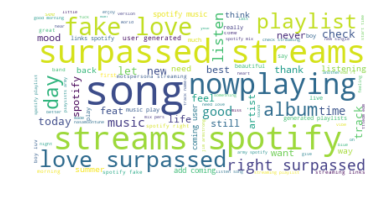

In [86]:
#Collecting tokenized tweet text into one list
all_tokenized_tweet_text = []
for token_list in list(data_df['Tokenized Tweet Text']):
    for token in token_list:
        all_tokenized_tweet_text.append(token)

#Joining tokenized tweet text list into one str
joined_tweet_text = " ".join(all_tokenized_tweet_text)

STOPWORDS.update(['a', 'my', 'i', 'the', 'am','now','know','information','always','follow','people','thing','us','will',
                 'make','go','take','de','la','account','one','en','things','million','wanna','got', 'don', 'forget'])

tweet_text_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(joined_tweet_text)
plt.figure()
plt.imshow(tweet_text_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### All User Profile Descriptions Word Cloud

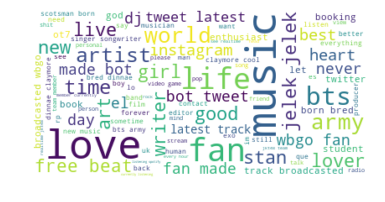

In [87]:
#Collecting tokenized profile text into one list
all_tokenized_profile_text = []

for token_list1 in list(data_df['Tokenized User Profile Description']):
    for token1 in token_list1:
        all_tokenized_profile_text.append(token1)

#Joining tokenized profile text list into one str
joined_profile_text = " ".join(all_tokenized_profile_text)

STOPWORDS.update(['bt', 'ig'])

profile_text_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(joined_profile_text)
plt.figure()
plt.imshow(profile_text_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [88]:
def filter_tweets_by_track_valence(track_valence, df=data_df):
    """
    Takes a pd.DataFrame (default = data_df) and desired avg
    track valence level as a str ('negative', 'neutral', 'positive')
    and returns a subset of Tweets with linked Spotify media 
    meeting the given criteria.
    
    @df: pd.DataFrame(default = data_df)
    @return: truncated pd.DataFrame    
    """
    positive_tweet_ids = []
    negative_tweet_ids = []
    neutral_tweet_ids = []
    
    for tweet_id in list(data_df.index):
        spotify_dict = data_df.loc[tweet_id, 'Spotify Tracks']
        valences_by_tweet = []
        
        for track_id in spotify_dict.keys():
            if type(spotify_dict[track_id]) == dict:
                for track_var in spotify_dict[track_id].keys():
                    if track_var == 'valence':
                        valences_by_tweet.append(spotify_dict[track_id]['valence'])
                        
                        if spotify_dict[track_id]['valence'] >= .75:
                            positive_tweet_ids.append(tweet_id)
                            
                        if spotify_dict[track_id]['valence'] <= .25:
                            negative_tweet_ids.append(tweet_id)
                            
                        if spotify_dict[track_id]['valence'] > .25 and spotify_dict[track_id]['valence'] < .75:
                            neutral_tweet_ids.append(tweet_id)
                            
            
            #Taking avg valence of tracks within a Tweet            
            avg_valence_by_tweet = np.mean(valences_by_tweet)
            
            #Adding new column to df, 'Average Track Valence'
            df.loc[tweet_id, 'Average Track Valence'] = avg_valence_by_tweet
            
    if track_valence == 'negative':
        #Tweets w/ average track valence <= 0.25 on 0 to 1.0 scale
        negative_tweets = df[df['Average Track Valence'] <= 0.25]
        print('There are '+ str(len(negative_tweets.index)) + ' Tweets with negatively valenced tracks on average.')
        
        #Uncomment for function to filter accroding to at least 1 negatively valuenced track
        #print('There are '+ str(len(negative_tweet_ids)) + ' Tweets with at least 1 negatively valenced track.')
        #negative_tweets = df.loc[negative_tweet_ids]
        return negative_tweets
        
    if track_valence == 'positive':
        #Tweets w/ average track valence >= 0.75
        positive_tweets = df[df['Average Track Valence'] >= 0.75]
        print('There are '+ str(len(positive_tweets.index)) + ' Tweets with positively valenced tracks on average.')
        
        #Uncomment for function to filter according to at least 1 positively valenced track
        #print('There are ' + str(len(positive_tweet_ids)) + ' Tweets with at least 1 positively valenced track.')
        #positive_tweets = df.loc[positive_tweet_ids]        
        return positive_tweets
    
    if track_valence == 'neutral':
        #Tweets w/ average track valence between 0.25 and 0.75
        neutral_tweets = df[(df['Average Track Valence'] > 0.25) & (df['Average Track Valence'] < 0.75)]
        print('There are '+ str(len(neutral_tweets.index)) + ' Tweets with neutrally valenced tracks on average.')
        
        #Uncomment for function to filter according to at least 1 neutrally valenced track
        #print('There are ' + str(len(neutral_tweet_ids)) + ' Tweets with at least 1 neutrally valenced track.')
        #neutral_tweets = df.loc[neutral_tweet_ids]
        return neutral_tweets        

In [89]:
#Running filter_tweets_by_track_valence

negative_filter = filter_tweets_by_track_valence('negative')
positive_filter = filter_tweets_by_track_valence('positive')
neutral_filter = filter_tweets_by_track_valence('neutral')

C:\Users\megha\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\megha\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


There are 2128 Tweets with negatively valenced tracks on average.
There are 1520 Tweets with positively valenced tracks on average.
There are 8289 Tweets with neutrally valenced tracks on average.


In [90]:
#Views on filter_tweets_by_track_valence dfs

positive_filter.head()
neutral_filter.head()
negative_filter.head()

,Coordinates,Creation Date Time,Favorites Count,Follower Count,Friend Count,Media URLs,Member Since,Place,Retweet Count,Spotify Tracks,...,Tokenized Tweet Text,Tokenized User Profile Description,Tweet ID,Tweet Text,User ID,User Location,User Name,User Profile Description,User Screename,Average Track Valence
1136654035648430081,NaN,2019-06-06 15:20:14,2603,568,563,"[{'url': 'https://t.co/rDZAgUBTKC', 'expanded_...",2018-10-04 18:33:04,NaN,1,{'1HpzOCZbNWzxvvXfSGtSrX': {'danceability': 0....,...,"[don’t, sleep, on, her, lt;3]","[album, 2, track, 12]",1136654035648430081,don’t sleep on her &lt;3,1047917533687373824,loading,Rita,album 2 track 12,httpangels5,0.164
1136653981713874950,NaN,2019-06-06 15:20:01,1298,154,670,"[{'url': 'https://t.co/jPwoBTtRhR', 'expanded_...",2010-07-14 11:04:25,NaN,0,{'5BRN9l6QmQPNvHmugO2rwW': {'danceability': 0....,...,"[winter, dusk, awakening, by, god, is, an, ast...",[],1136653981713874950,Winter Dusk/awakening by God Is An Astronaut #...,166526076,,Derek,,DerekT86,0.214
1136653980304584706,NaN,2019-06-06 15:20:01,27029,1714,1059,"[{'url': 'https://t.co/ibi6N7InNn', 'expanded_...",2010-07-09 02:50:23,NaN,0,{'6RYvgoZ0VANIOBIjShqkfz': {'danceability': 0....,...,"[picking, up, the, pieces, de, paloma, faith]","[been, trying, hard, not, to, get, into, troub...",1136653980304584706,Picking Up the Pieces de Paloma Faith,164527692,"São Carlos, Brasil",Quero cafééé,Been trying hard not to get into trouble but I...,gabriel_vfr,0.242
1136653943524724736,NaN,2019-06-06 15:19:52,10158,18929,18716,"[{'url': 'https://t.co/b2fr3KoiRS', 'expanded_...",2009-08-03 00:19:35,NaN,0,{'2JWTVS3ndZcwJrabnCAWvD': {'danceability': 0....,...,"[hotel, by, dylan, sitts, nowplaying]","[internet, graffiti, artist, and, a, hipster, ...",1136653943524724736,Hotel by Dylan Sitts #NowPlaying,62387515,"Kansas City, MO",Bookstore Illuminati,Internet graffiti artist and a hipster hermeti...,EthericOps,0.149
1136653943315075072,NaN,2019-06-06 15:19:52,701,341,312,"[{'url': 'https://t.co/s8LnBnZbVf', 'expanded_...",2018-11-03 23:18:28,NaN,0,{'3Af48nXaNAiOPlcM0ZBl5A': {'danceability': 0....,...,"[love, this, band]","[you, get, used, to, disappointment, after, sp...",1136653943315075072,love this band.,1058860993567211522,Roamin' New York,Cain Reed,You get used to disappointment after spending ...,BedlamWithin,0.217


#### Word Clouds filtered for Spotify Track Valence

#### Positive Tweet Text Word Cloud

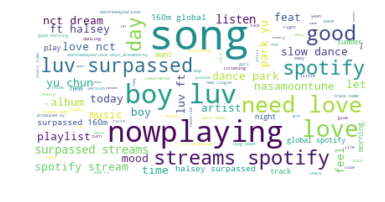

In [91]:
#Collecting tokenized tweet text for tweets w/ avg positively valenced track into one list
positive_tokenized_tweet_text = []

for token_list2 in list(positive_filter['Tokenized Tweet Text']):
    for token2 in token_list2:
        positive_tokenized_tweet_text.append(token2)

#Joining positive tokenized tweet text list into one str
joined_positive_text = " ".join(positive_tokenized_tweet_text)

STOPWORDS.update(['pers', 'user', 'add', 'generated'])

positive_text_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(joined_positive_text)
plt.figure()
plt.imshow(positive_text_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Positive Profile Description Word Cloud

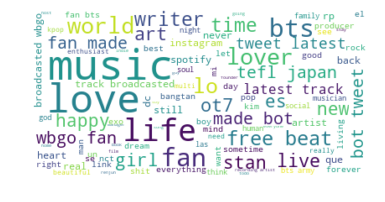

In [92]:
#Collecting tokenized profile text for Tweets w/ avg positively valenced track into one list
positive_tokenized_profile_text = []

for token_list4 in list(positive_filter['Tokenized User Profile Description']):
    for token4 in token_list4:
        positive_tokenized_profile_text.append(token4)

#Joining positive tokenized Tweet text list into one str
joined_positive_profile = " ".join(positive_tokenized_profile_text)

positive_profile_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(joined_positive_profile)
plt.figure()
plt.imshow(positive_profile_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative Tweet Text Word Cloud

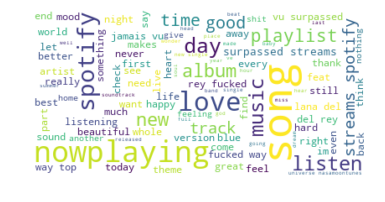

In [93]:
#Collecting tokenized tweet text for tweets w/ avg negatively valenced track into one list
negative_tokenized_tweet_text = []

for token_list3 in list(negative_filter['Tokenized Tweet Text']):
    for token3 in token_list3:
        negative_tokenized_tweet_text.append(token3)

#Joining negative tokenized tweet text list into one str
joined_negative_text = " ".join(negative_tokenized_tweet_text)

negative_text_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(joined_negative_text)
plt.figure()
plt.imshow(negative_text_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Negative Profile Description Word Cloud

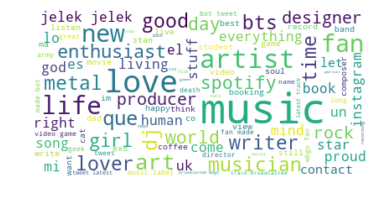

In [94]:
#Collecting tokenized profile text for tweets w/ avg negatively valenced track into one list
negative_tokenized_profile_text = []

for token_list5 in list(negative_filter['Tokenized User Profile Description']):
    for token5 in token_list5:
        negative_tokenized_profile_text.append(token5)

#Joining negative tokenized profile text list into one str
joined_negative_profile = " ".join(negative_tokenized_profile_text)

negative_profile_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(joined_negative_profile)
plt.figure()
plt.imshow(negative_profile_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## References 

1. Spotipy Documentation: https://spotipy.readthedocs.io/en/latest/
2. Twython Documentation: https://twython.readthedocs.io/en/latest/
3. Spotify API Documentation: https://developer.spotify.com/documentation/web-api/reference-beta/
4. Twitter API Documentation:https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
5. Bollen, Mao & Pepe (2011) - PMOS: https://www.aaai.org/ocs/index.php/ICWSM/ICWSM11/paper/viewFile/2826/3237